## UniFi: A Unified Framework for Portfolio Management Demo

### Imports packages

In [234]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [235]:
from sys import path
from os.path import dirname as dir
path.append(dir(path[0]))
from statistics import median
from AgentLayer.ConventionalAgents.LRAgent import LRAgent
from AgentLayer.ConventionalAgents.SVRAgent import SVRAgent
from AgentLayer.DataSplitter.TimeSeriesSplitter import TimeSeriesSplitter
from FinancialDataLayer.DataCollection.DataDownloader import DataDownloader
from FinancialDataLayer.DataProcessing.DefaultFeatureEngineer import DefaultFeatureEngineer
from EvaluationLayer.PortfolioEvaluator import PortfolioEvaluator
from EvaluationLayer.CustomPortfolioEvaluator import CustomPortfolioEvaluator
from EvaluationLayer.Evaluator import Evaluator
from EvaluationLayer.SharpeStats import *
from AgentLayer.RLAgents.A2C import A2C
from AgentLayer.Environment.PortfolioEnv import PortfolioEnv
import yaml
import numpy as np
from AgentLayer.metrics import *
import pandas as pd
import datetime

### Import user parameters

In [416]:
# IMPORT .yaml FILE
# Gather user parameters
with open("..//user_params.yaml", "r") as stream:
    try:
        user_params = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

tickers = user_params["TICKERS"]
tech_indicator_list = user_params["FEATURE_ENG_PARAMS"]["tech_indicator_list"]
feature_eng_params = user_params["FEATURE_ENG_PARAMS"]
train_params = user_params["TRAIN_PARAMS"]
trade_params = user_params["TEST_PARAMS"]
policy_params = user_params["POLICY_PARAMS"]
test_params = user_params["TEST_PARAMS"]
feature_list = env_kwargs["feature_list"]
train_start = user_params["TRAIN_START_DATE"]
train_end = user_params["TRAIN_END_DATE"]
trade_start = user_params["TRADE_START_DATE"]
trade_end = user_params["TRADE_END_DATE"]

In [7]:
tech_indicator_list

['macd',
 'boll_ub',
 'boll_lb',
 'rsi_30',
 'cci_30',
 'dx_30',
 'close_30_sma',
 'close_60_sma']

In [8]:
feature_list

['macd',
 'boll_ub',
 'boll_lb',
 'rsi_30',
 'cci_30',
 'dx_30',
 'close_30_sma',
 'close_60_sma',
 'close']

### Download data

In [531]:
# FETCH DATA
downloaded_df = DataDownloader(start_date=train_start,
                                end_date=trade_end,
                                ticker_list=tickers).collect()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (8432, 8)


In [532]:
downloaded_df.head()

,date,open,high,low,close,volume,tic,day
0,2007-12-31,7.125000,7.160714,7.062500,6.048639,539333200,AAPL,0
1,2007-12-31,88.139999,88.279999,87.239998,64.097237,3184200,BA,0
2,2007-12-31,73.000000,73.709999,72.389999,48.465950,2639600,CAT,0
3,2007-12-31,94.370003,94.580002,93.010002,53.035442,5086600,CVX,0
4,2008-01-02,7.116786,7.152143,6.876786,5.949704,1079178800,AAPL,2


### Preprocess Data

In [11]:
data_processor = DefaultFeatureEngineer(**feature_eng_params)
# add technical indicators as features
df_processed = data_processor.extend_data(downloaded_df)

Successfully added technical indicators
Successfully added covariances
Successfully added returns


In [12]:
df_processed.head()

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,cov_list,return_list
0,2009-12-30,AAPL,7.458214,7.571429,7.439643,6.462715,412084400.0,2.0,0.095174,6.478916,5.641878,61.152182,150.672119,28.405596,6.101846,6.037638,"[[0.00045722526934112965, 0.000256460137273116...",tic AAPL BA CAT ...
0,2009-12-30,BA,54.860001,55.290001,54.750000,42.826881,2461000.0,2.0,0.536569,43.969526,41.723191,56.637403,46.516669,5.646709,42.169463,40.660286,"[[0.00045722526934112965, 0.000256460137273116...",tic AAPL BA CAT ...
0,2009-12-30,CAT,57.980000,58.220001,57.750000,41.561871,3479800.0,2.0,0.111334,42.411626,40.378458,54.616452,-9.923547,3.203872,41.595037,40.957748,"[[0.00045722526934112965, 0.000256460137273116...",tic AAPL BA CAT ...
0,2009-12-30,CVX,77.099998,77.669998,77.000000,47.207272,4300800.0,2.0,0.034518,47.734679,46.510845,54.431340,-56.766336,5.005667,47.313456,46.593324,"[[0.00045722526934112965, 0.000256460137273116...",tic AAPL BA CAT ...
1,2009-12-31,AAPL,7.611786,7.619643,7.520000,6.434926,352410800.0,3.0,0.105229,6.531585,5.633488,60.406021,155.827557,31.312029,6.105642,6.048183,"[[0.0004566261935095321, 0.0002589241176314950...",tic AAPL BA CAT ...


### Train-Test split

In [13]:
# split data to train and test
splitter = TimeSeriesSplitter()
train = splitter.get_split_data(df_processed, train_start, train_end)
trade_period=splitter.get_split_data(df_processed, trade_start, trade_end).date.unique()

In [14]:
train.head()

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,cov_list,return_list
0,2009-12-30,AAPL,7.458214,7.571429,7.439643,6.462715,412084400.0,2.0,0.095174,6.478916,5.641878,61.152182,150.672119,28.405596,6.101846,6.037638,"[[0.00045722526934112965, 0.000256460137273116...",tic AAPL BA CAT ...
0,2009-12-30,BA,54.860001,55.290001,54.750000,42.826881,2461000.0,2.0,0.536569,43.969526,41.723191,56.637403,46.516669,5.646709,42.169463,40.660286,"[[0.00045722526934112965, 0.000256460137273116...",tic AAPL BA CAT ...
0,2009-12-30,CAT,57.980000,58.220001,57.750000,41.561871,3479800.0,2.0,0.111334,42.411626,40.378458,54.616452,-9.923547,3.203872,41.595037,40.957748,"[[0.00045722526934112965, 0.000256460137273116...",tic AAPL BA CAT ...
0,2009-12-30,CVX,77.099998,77.669998,77.000000,47.207272,4300800.0,2.0,0.034518,47.734679,46.510845,54.431340,-56.766336,5.005667,47.313456,46.593324,"[[0.00045722526934112965, 0.000256460137273116...",tic AAPL BA CAT ...
1,2009-12-31,AAPL,7.611786,7.619643,7.520000,6.434926,352410800.0,3.0,0.105229,6.531585,5.633488,60.406021,155.827557,31.312029,6.105642,6.048183,"[[0.0004566261935095321, 0.0002589241176314950...",tic AAPL BA CAT ...


## Agent Layer

### Model creation

In [15]:
# Create Linear Regression model and train it
svr = SVRAgent(**policy_params["SVR_PARAMS"])

### Offline training

In [16]:
x_train, y_train = data_processor.prepare_ml_data(train, feature_list)
svr.train_model(x_train, y_train, **train_params["SVR_PARAMS"])

Model trained succesfully


### Online training

In [19]:
SVR_portfolio_df = pd.DataFrame(columns = ["date", "account_value"])
SVR_portfolio_df["date"] = pd.to_datetime(SVR_portfolio_df["date"])
initial_capital=trade_params["SVR_PARAMS"]["initial_capital"]
for i, train_day in enumerate(trade_period):
    if i==len(trade_period)-1:
        break
    else:
        print(train_day)
        trade = splitter.get_split_data(df_processed, train_day, splitter.get_next_df_date(df_processed, train_day))    
        next_SVR_portfolio_df, next_SVR_meta_coefficient = svr.predict(trade, initial_capital=initial_capital, feature_list=feature_list)
        initial_capital=next_SVR_portfolio_df["account_value"][1]

        if i == 0:
            SVR_portfolio_df = pd.concat([SVR_portfolio_df.copy(), next_SVR_portfolio_df])
        else:
            SVR_portfolio_df = pd.concat([SVR_portfolio_df.copy(), next_SVR_portfolio_df.iloc[1:]])

        train = splitter.get_split_data(df_processed, train_start, splitter.get_next_df_date(df_processed, train_day))
        x_train, y_train = data_processor.prepare_ml_data(train, feature_list)
        sample_weight = [0.99**i for i in range(len(train.index.unique())-1)]
        sample_weight = sorted(sample_weight*len(tickers))

        svr.train_model(x_train, y_train, sample_weight=sample_weight)

2015-12-31T00:00:00.000000000
Model trained succesfully
2016-01-04T00:00:00.000000000
Model trained succesfully
2016-01-05T00:00:00.000000000
Model trained succesfully
2016-01-06T00:00:00.000000000
Model trained succesfully
2016-01-07T00:00:00.000000000
Model trained succesfully
2016-01-08T00:00:00.000000000
Model trained succesfully
2016-01-11T00:00:00.000000000
Model trained succesfully
2016-01-12T00:00:00.000000000
Model trained succesfully
2016-01-13T00:00:00.000000000
Model trained succesfully
2016-01-14T00:00:00.000000000
Model trained succesfully
2016-01-15T00:00:00.000000000
Model trained succesfully
2016-01-19T00:00:00.000000000
Model trained succesfully
2016-01-20T00:00:00.000000000
Model trained succesfully
2016-01-21T00:00:00.000000000
Model trained succesfully
2016-01-22T00:00:00.000000000
Model trained succesfully
2016-01-25T00:00:00.000000000
Model trained succesfully
2016-01-26T00:00:00.000000000
Model trained succesfully
2016-01-27T00:00:00.000000000
Model trained succ

In [20]:
SVR_portfolio_df

,date,account_value
0,2015-12-31,1000000
1,2016-01-04,987661.256288
1,2016-01-05,996109.526045
1,2016-01-06,956758.401522
1,2016-01-07,922854.515717
...,...,...
1,2016-05-09,1129644.608543
1,2016-05-10,1140000.897732
1,2016-05-11,1138537.458782
1,2016-05-12,1149569.52835


## Evaluation

### Environment creation 

In [ ]:
# CREATE TRAIN ENV
env = PortfolioEnv(df=train, **env_kwargs)
env_train, _ = env.get_env()
# CREATE TEST ENV
env_test = PortfolioEnv(df=trade, **env_kwargs)

In [ ]:
# CREATE A2C AGENT
a2c = A2C(env=env_train, **policy_params["A2C_PARAMS"])

### Agent training 

In [ ]:
# TRAIN A2C AGENT
a2c.train_model(**train_params["A2C_PARAMS"])

### Agent prediction

In [ ]:
# TEST A2C AGENT
A2C_portfolio_df, df_actions_a2c = a2c.predict(environment=env_test, **test_params["A2C_PARAMS"])

In [ ]:
A2C_portfolio_df

In [ ]:
df_actions_a2c

### Financial statistics

In [526]:
custom_evaluator = CustomPortfolioEvaluator(SVR_portfolio_df, agent_names=["SVR"], benchmark_tickers=tickers)

In [529]:
custom_evaluator.backtest_stats()

,Annual return,Cumulative returns,Annual volatility,Sharpe ratio,Calmar ratio,Stability,Max drawdown,Omega ratio,Sortino ratio,Skew,Kurtosis,Tail ratio,Daily value at risk,Prob. Sharpe (vs benchmark),Prob. Sharpe (vs zero skill)
SVR,0.411331,0.134035,0.322191,1.229079,3.370066,0.873676,-0.122054,1.222906,1.890269,0.079819,0.002891,1.156142,-0.039021,0.773938,0.770278
Uniform Buy and Hold,-0.033936,-0.012661,0.244375,-0.020135,-0.247398,0.649982,-0.137172,0.996715,-0.028207,-0.179253,0.163709,1.076838,-0.030808,0.500000,0.495146


Due to the random walk nature of the price data, it is not enough to backtest the returns "historically" since history is only "one" occurance of infinite possible realizations of the this Geometric brownian motion. Therefore, it is more informative to look at the "distribution" of returns.

According to Marcos Lopez de Prado and David H. Bailey, sharpe ratios are not comparable, unless controlled for the skewness and kurtosis of the returns. To solve this problem they have developed the Probabilistic Sharpe Ratio (PSR). PSR takes those characteristics into account and delivers a corrected, atemporal measure of performance expressed in terms of "probability of skill". Therefore, PSR indicates the probability of a given strategy to have a True SR greater than a given benchmark.

Comparing against zero skill, when SR benchmark = 0:
In this example, we can say with a 77.02% confidence that the SVR agent is a winner strategy (ie. it can generate alpha). However, for the benchmark of "uniform buy and hold", we "only" have a certainty of 49.51% that it can generate alpha.

Comparing against a benchmark strategy, (when the given SR benchmark is equal to historical SR of the benchmark strategy):
The PSR also allows us to compare our trained agent directly against the benchmark strategy and gauge whether our trained strategy is significantly better than the benchmark strategy. Therefore the PSR against benchmark indicates the probability of the trained strategy to be the better strategy compared to the benchmark strategy.

Therefore, PSR is valuable also in difficuly in cases where we have to choose between multiple strategies with equally attractive Sharpe Ratios, since it gives a confidence level around that number.

Start date,2016-01-04
End date,2016-05-13
Total months,4
,Backtest
Annual return,41.133%
Cumulative returns,13.403%
Annual volatility,32.219%
Sharpe ratio,1.23
Calmar ratio,3.37
Stability,0.87
Max drawdown,-12.205%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,11.86,2016-01-05,2016-01-20,2016-02-22,35
1,6.06,2016-02-22,2016-02-29,2016-03-07,11
2,5.14,2016-03-18,2016-04-05,2016-04-14,20
3,3.37,2016-04-27,2016-05-09,NaT,NaN
4,2.13,2016-03-07,2016-03-08,2016-03-09,3


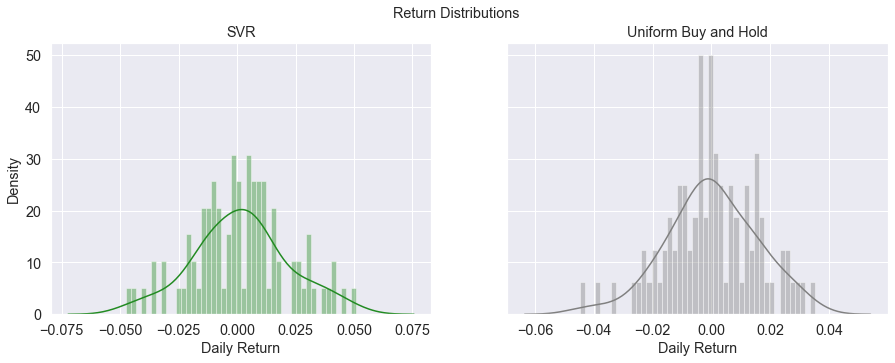

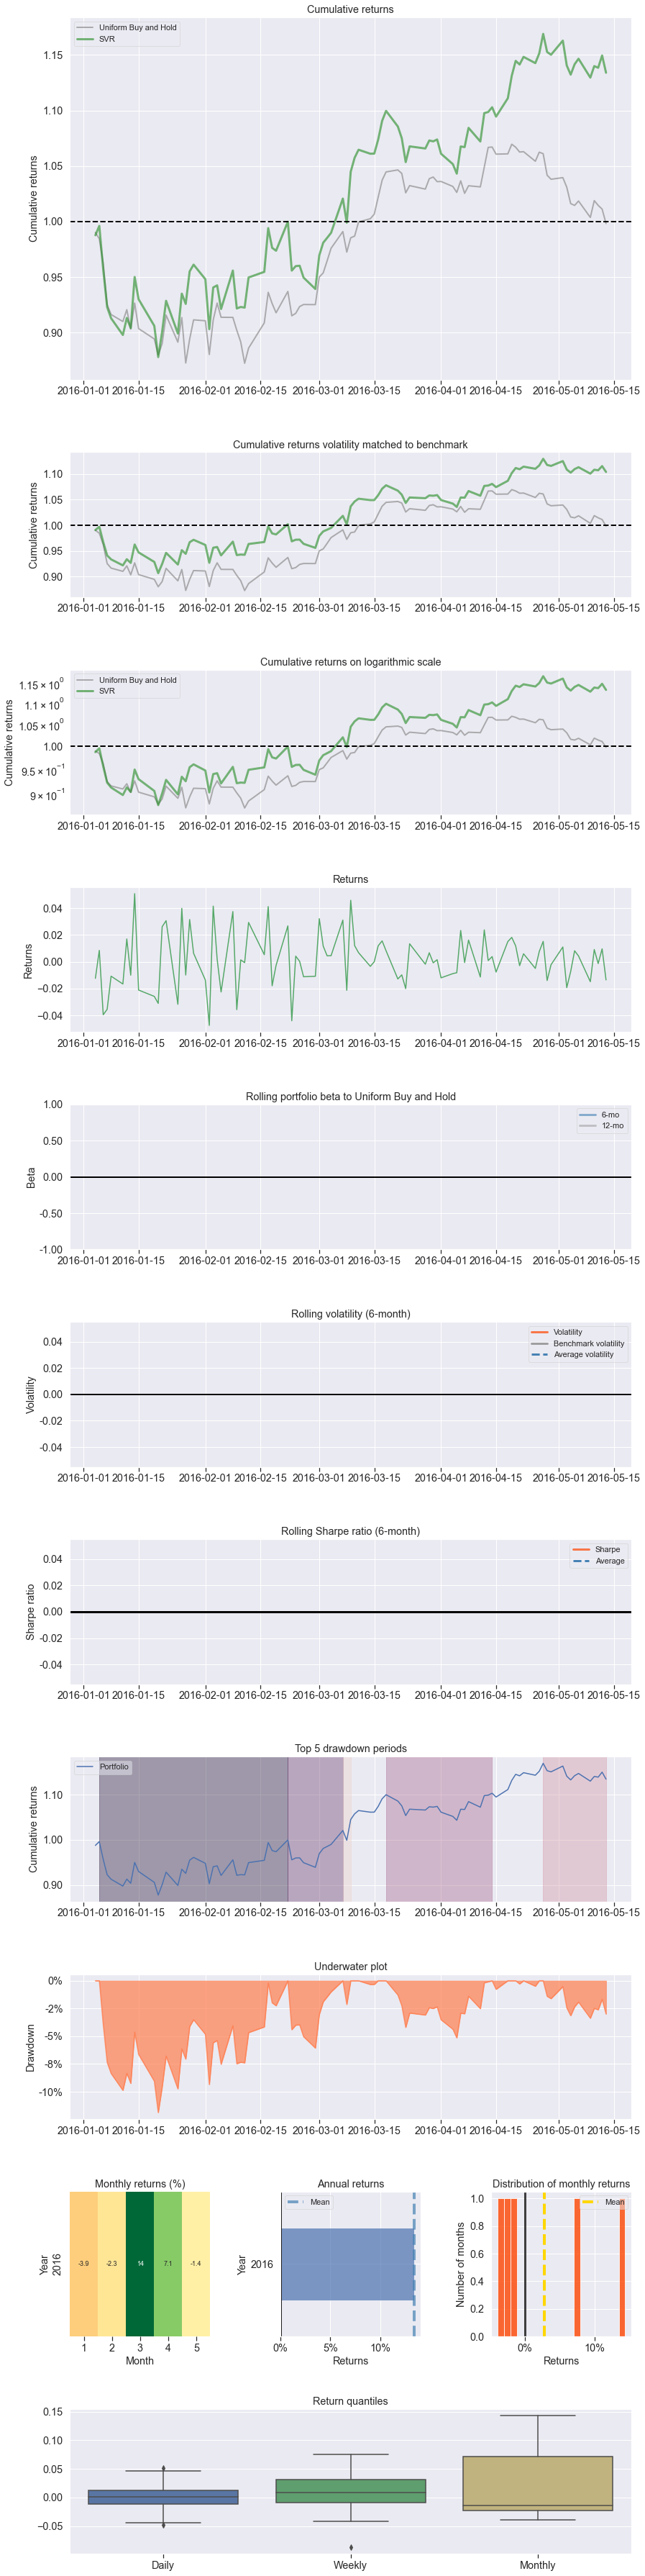

In [530]:
custom_evaluator.backtest_plot()

### Model saving

In [ ]:
#Save model
svr.save_model("svr_model")

### Model loading

In [ ]:
#Load model
my_model = svr.load_model("svr_model")